In [1]:
# Import libraries
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
K.set_image_data_format('channels_first')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from fr_utils import *
from inception_blocks_v2 import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
FRmodel = faceRecoModel(input_shape=(3, 96, 96))

In [3]:
print("Total Params:", FRmodel.count_params())

Total Params: 3743280


In [4]:
# triplet_loss
def triplet_loss(y_true, y_pred, alpha = 0.2):
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    pos_dist = tf.reduce_sum((tf.square(tf.subtract(anchor,positive))))
    neg_dist = tf.reduce_sum((tf.square(tf.subtract(anchor,negative))))
    basic_loss = tf.add(tf.subtract(pos_dist,neg_dist),alpha)
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))    
    return loss

In [5]:
# Predict session
with tf.Session() as test:
    tf.set_random_seed(1)
    y_true = (None, None, None)
    y_pred = (tf.random_normal([3, 128], mean=6, stddev=0.1, seed = 1),
              tf.random_normal([3, 128], mean=1, stddev=1, seed = 1),
              tf.random_normal([3, 128], mean=3, stddev=4, seed = 1))
    loss = triplet_loss(y_true, y_pred)
    
    print("loss = " + str(loss.eval()))

loss = 350.026


In [6]:
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])

In [7]:
load_weights_from_FaceNet(FRmodel)

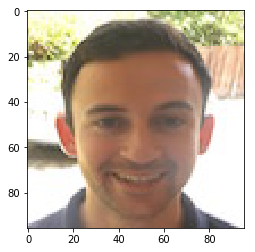

In [9]:
img=mpimg.imread("images/camera_0.jpg")
imgplot = plt.imshow(img)
plt.show()

In [12]:
database = {}
database["danielle"] = img_to_encoding("images/danielle.png", FRmodel)
database["younes"] = img_to_encoding("images/younes.jpg", FRmodel)
database["tian"] = img_to_encoding("images/tian.jpg", FRmodel)
database["kian"] = img_to_encoding("images/kian.jpg", FRmodel)
database["dan"] = img_to_encoding("images/dan.jpg", FRmodel)
database["sebastiano"] = img_to_encoding("images/sebastiano.jpg", FRmodel)
database["bertrand"] = img_to_encoding("images/bertrand.jpg", FRmodel)
database["kevin"] = img_to_encoding("images/kevin.jpg", FRmodel)
database["felix"] = img_to_encoding("images/felix.jpg", FRmodel)
database["benoit"] = img_to_encoding("images/benoit.jpg", FRmodel)
database["arnaud"] = img_to_encoding("images/arnaud.jpg", FRmodel)

In [13]:
def verify(image_path, identity, database, model):
    encoding = img_to_encoding(image_path, model)
    dist = np.linalg.norm((encoding - database[identity]), ord = 2)
    if dist < 0.7:
        print("It's " + str(identity) + ", welcome home!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = False        
    return dist, door_open

In [14]:
verify("images/camera_0.jpg", "younes", database, FRmodel)

It's younes, welcome home!


(0.65939283, True)

In [15]:
verify("images/camera_2.jpg", "kian", database, FRmodel)

It's not kian, please go away


(0.86224014, False)

In [16]:
def who_is_it(image_path, database, model):
    encoding = img_to_encoding(image_path, model)
    min_dist = 100
    for (name, db_enc) in database.items():
        dist = np.linalg.norm((encoding - db_enc), ord = 2)
        if dist < min_dist:
            min_dist = dist
            identity = name    
    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity

In [17]:
who_is_it("images/camera_0.jpg", database, FRmodel)

it's younes, the distance is 0.659393


(0.65939283, 'younes')